
 <img src="https://drive.google.com/uc?export=view&id=1tnnZBY1N2opO-QLoPdHdAHOcnL4oi-Lx" alt="" style="width: 250px;"/>

When it comes to machine learning, handling class imbalance is very critical. Even if you get good accuracy over the test set, the model will be misleading. So handling class imbalance and selecting right metrices to evaluate them is important. Let's take a look at the pupular methods to handle the problem.


#### Index

* Imabalanced Datasets
* Resampling Overview
* Resampling with Pandas
* Resampling with Imbalanced learn
* Training base model
* K-fold validation is the right way
* Evaluation metrices
* Findings

In [1]:
!pip install chart-studio

     |████████████████████████████████| 81kB 3.8MB/s 


Load libraries and dataset

In [2]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings('ignore')
# %matplotlib inline

In [3]:
# load dataset
train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')

train_data = train_data.sample(n=1000)
test_data = test_data.sample(n=1000)

Let's do some EDA

In [4]:
# print the shape of datasets
print('Shape of train dataset : ', train_data.shape)
print('Shape of test dataset : ', test_data.shape)

# sample entries from the train dataset
train_data.head()

Shape of train dataset :  (1000, 202)
Shape of test dataset :  (1000, 201)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
160308,train_160308,0,7.7931,4.5405,9.2971,9.9131,10.8653,-18.8457,5.0160,17.3438,...,2.5838,7.2366,0.9600,3.5103,17.5835,1.6799,14.0165,10.6195,9.8950,-19.6249
99553,train_99553,0,9.8339,-5.2164,7.8739,6.2944,12.9420,-1.0705,5.8288,15.5811,...,-4.6780,3.1292,1.0314,9.4993,22.1232,-0.6612,0.2098,10.1077,16.0344,-9.2735
95704,train_95704,0,6.1279,-7.2821,7.3174,5.4273,9.6883,-5.2170,5.8166,17.4333,...,-0.5013,8.9612,4.1851,1.8730,20.0137,-2.3246,-3.2573,10.1237,15.3187,10.1541
119795,train_119795,0,12.8636,-1.3840,10.8872,5.4490,12.1876,-8.7630,5.7746,12.6651,...,-1.3621,6.2037,1.7058,0.5244,18.8725,-1.1905,-1.1878,8.1790,18.9493,-3.7565
101502,train_101502,0,15.1346,-1.0590,13.0756,8.7861,12.6182,0.3158,4.9834,21.6513,...,2.8544,14.9648,0.3843,4.9055,16.0299,-1.2322,1.0739,10.0719,13.5885,-17.4168


In [5]:
# Now time to handle the missing values
print('Missing values in the train dataset : ', train_data[train_data.isnull()].count().sum())
print('Missing values in the test dataset : ', test_data[test_data.isnull()].count().sum())

Missing values in the train dataset :  0
Missing values in the test dataset :  0


So let's neglect the part of data imputation

The Target column.
Is the 'target' variable balanced?

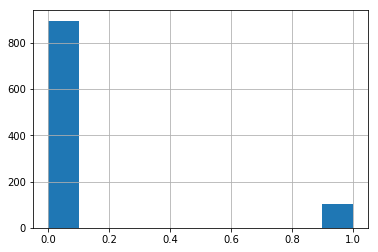

In [6]:
# Is the 'target' variable biased?
train_data['target'].hist()

yes, it is.

In [7]:
# the counts
majority_class_count, minority_class_count = train_data['target'].value_counts()
print('The majority class count :  ', majority_class_count)
print('The minority class count :  ', minority_class_count)


The majority class count :   896
The minority class count :   104


In [8]:
# majority and minority class dataframes
train_data_majority_class = train_data[train_data['target'] == 0]
train_data_minority_class = train_data[train_data['target'] == 1]

maj_class_percent = round((majority_class_count/minority_class_count)/len(train_data)*100)
min_class_percent = round((minority_class_count/minority_class_count)/len(train_data)*100)

print('Majority class (%): ', maj_class_percent)
print('Minority class (%): ', minority_class_count)

Majority class (%):  1
Minority class (%):  104


The above results shows that the presence of class imbalance.

### Imbalanced Dataset
Let us explore the dataset in detail to check the distribution and by what extend the imbalance is present.[](http://)

In [9]:
# let's introduce a new plot function for visualizing the impacts
def plot2DClusters(X,y,label='Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='Upper right')
    plt.show()


    
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

def plot3DClusters(dataset):
    fig = px.scatter_3d(dataset, x='dim-1', y='dim-2', z='dim-3', color='target', opacity=0.8)
    iplot(fig, filename='jupyter-parametric_plot')

Let's select the most important 3 features with dimensionality reduction. So we will get a better visulalization of class distribution.

In [10]:
# split the dataset into labels and IVs
X = train_data.drop(['ID_code', 'target'], axis=1)
y = train_data['target']

temp_X_holder = X
temp_y_holder = y


# It is not practical to visualize the classes or clusters in the dataset using 2DPlot (as dimensions > 3)
# So we will perform the PCA to reduce the dimension
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
X = pca.fit_transform(temp_X_holder)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = temp_y_holder.values
plot3DClusters(test)

And in 2d-space it looks like.

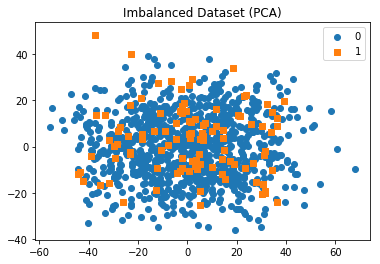

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X = pca.fit_transform(temp_X_holder)

plot2DClusters(X,temp_y_holder.values,label='Imbalanced Dataset (PCA)')

### Resampling
From the above results it is clear that class imbalance is present in the target column. <br>
So any model that is created on top of it will be misleading. Hence we need to resample the dataset. <br> <br>

To resample the dataset, there are two approaches available. Which are,
1. <b>Under Sampling</b> : delete random data points from the major class.
2. <b>Over Sampling</b> : add or replicate the sample data points from the minor class.

 <img src="https://drive.google.com/uc?export=view&id=1TUS-mnR1AyKPyXzrpKkqN8KaseKbd3OC" alt="" width="600" />


### Resampling with Pandas
Let's use the built in methods of pandas to resample the dataset.

#### 1. Under Sampling with Pandas
Random under sampling of major class.

In [12]:
new_train_data_majority_class = train_data_majority_class.sample(minority_class_count, replace=True)

# create new dataset
downsampled_data = pd.concat([train_data_minority_class, new_train_data_majority_class], axis=0)

1    104
0    104
Name: target, dtype: int64


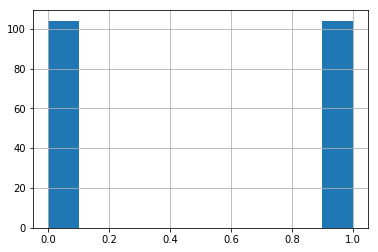

In [13]:
# check results
print(downsampled_data['target'].value_counts())
downsampled_data['target'].hist()

In [14]:
# split the dataset into labels and IVs
y = downsampled_data['target']
X = downsampled_data.drop(['ID_code', 'target'], axis=1)

temp_X_holder = X
temp_y_holder = y


# It is not practical to visualize the classes or clusters in the dataset using 2DPlot (as dimensions > 3)
# So we will perform the PCA to reduce the dimension
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
X = pca.fit_transform(temp_X_holder)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = temp_y_holder.values
plot3DClusters(test)

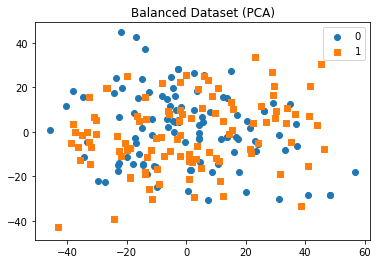

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X = pca.fit_transform(temp_X_holder)

plot2DClusters(X,temp_y_holder.values,label='Balanced Dataset (PCA)')

#### 2. Over Sampling with Pandas
Random over sampling of major class.

1    896
0    896
Name: target, dtype: int64


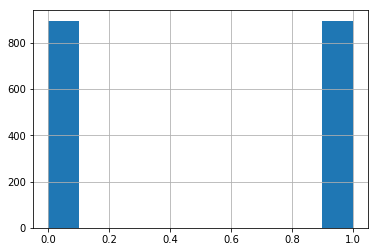

In [16]:
new_train_data_minority_class = train_data_minority_class.sample(majority_class_count, replace=True) \

# concatenate the dataframes to create the new one
upsampled_data = pd.concat([new_train_data_minority_class, train_data_majority_class], axis=0)

# check the results
print(upsampled_data['target'].value_counts())
upsampled_data['target'].hist()

In [17]:
# split the dataset into labels and IVs
y = upsampled_data['target']
X = upsampled_data.drop(['ID_code', 'target'], axis=1)

temp_X_holder = X
temp_y_holder = y


# It is not practical to visualize the classes or clusters in the dataset using 2DPlot (as dimensions > 3)
# So we will perform the PCA to reduce the dimension
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
X = pca.fit_transform(temp_X_holder)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = temp_y_holder.values
plot3DClusters(test)

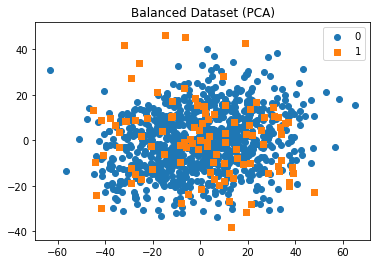

In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X = pca.fit_transform(temp_X_holder)

plot2DClusters(X,temp_y_holder.values,label='Balanced Dataset (PCA)')

#### Findings
The random resampling methods are not enough to handle the class imbalance problem as,
* the model trained in the <b>Random Over Sampled dataset</b> will be over-fitting due to the presence of dupicate data points of minor class.
* the model trained in the <b>Random Under Sampled dataset</b> will lose many useful information. So model will be misleading one.
<br>
Hence it is clear that, we need more advanced methods to handle the class imbalance problem. Let's take a look at them.

### Resampling with Imbalanced learn Package
imblearn is the popular package used to perform resampling.<br>
It contains the Under, Over and Combined sampling methods. Let's take a look at the popular methods provided by it.

 <img src="https://drive.google.com/uc?export=view&id=1tyBEdstPU6zHzF4mSEsIydD5Z5vuhyRi" alt="" width="800" />


### 1. Under Sampling with imbalanced learn

#### 1.1 Down Sampling with Tomek Links
 The Tomek Links are the pairs of data points at the borders of the classes. <br>
 So removing the majority class elements from these instances (pairs) will increase the seperation between them.
 
<img src="https://drive.google.com/uc?export=view&id=1LlE-6dcgT2krMLxlkAI1gfROi2oZxhTR" alt="" width="700" />

In [19]:
from imblearn.under_sampling import TomekLinks

imb_tomek = TomekLinks(return_indices = True, ratio = 'majority')

X_imb_tomek, y_imb_tomek, Id_imb_tomek = imb_tomek.fit_sample(temp_X_holder, temp_y_holder)

print('Number of data points deleted : ', len(Id_imb_tomek))

Using TensorFlow backend.


Number of data points deleted :  1792


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09217642b0>]],
      dtype=object)

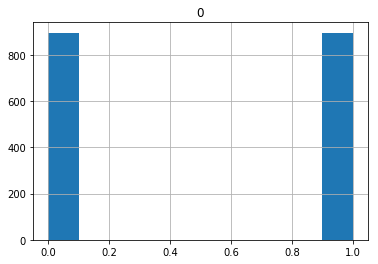

In [20]:
# let's check the results
X_imb_tomek = pd.DataFrame(X_imb_tomek)
y_imb_tomek = pd.DataFrame(y_imb_tomek)

y_imb_tomek.hist()

In [21]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_tomek)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_tomek.values
plot3DClusters(test)

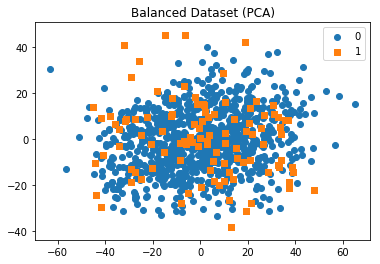

In [22]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_tomek)

plot2DClusters(X,y_imb_tomek[0],label='Balanced Dataset (PCA)')

#### 1.2 Down Sampling with Cluster Centroids
Here we will compute the centers of the clusters. And we will save it as new dataset.<br>
We can specify the number of centroids (if 10, then 10 centroids will be saved from class-0 and class-1)


In [23]:
from imblearn.under_sampling import ClusterCentroids

# imb_cc = ClusterCentroids(ratio={0:100}) # we want to save 100 points from each class
imb_cc = ClusterCentroids()
X_imb_cc, y_imb_cc = imb_cc.fit_sample(temp_X_holder, temp_y_holder)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0920e3a710>]],
      dtype=object)

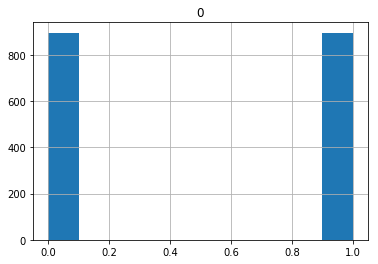

In [24]:
# let's check the results
X_imb_cc = pd.DataFrame(X_imb_cc)
y_imb_cc = pd.DataFrame(y_imb_cc)

y_imb_cc.hist()

In [25]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_cc)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_cc.values
plot3DClusters(test)

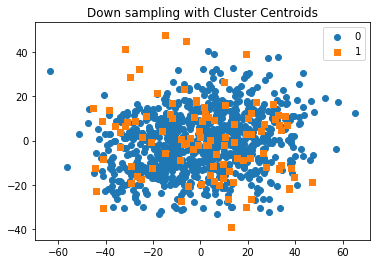

In [26]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_cc)

plot2DClusters(X, y_imb_cc[0],label='Down sampling with Cluster Centroids')

#### 1.3 Under Sampling with Nearmiss

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09206ee208>]],
      dtype=object)

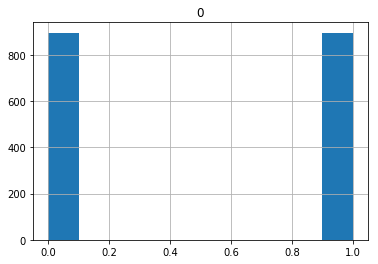

In [27]:
from imblearn.under_sampling import NearMiss

imb_nn = NearMiss() # we want to save 100 points from each class

X_imb_nn, y_imb_nn = imb_nn.fit_sample(temp_X_holder, temp_y_holder)

# let's check the results
X_imb_nn = pd.DataFrame(X_imb_nn)
y_imb_nn = pd.DataFrame(y_imb_nn)

y_imb_nn.hist()

In [28]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_nn)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_nn.values
plot3DClusters(test)

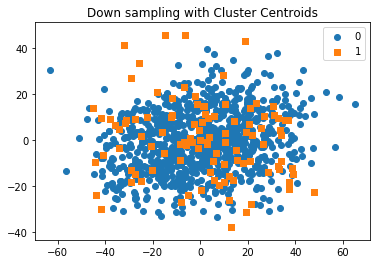

In [29]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_nn)

plot2DClusters(X, y_imb_nn[0],label='Down sampling with Cluster Centroids')

### 2. Over Sampling Methods

#### 2.1 Oversampling with SMOTE
Synthetic Minority Oversampling TEchnique. <br>
In which you will select random points from minority class, and computing the K nearest neighbours for that. <br>
Synthetic points are added between the selected point and it's neighbours. <br>

 <img src="https://drive.google.com/uc?export=view&id=19uM7CtuawkidIfBmW6U07ql6bbJoyNV4" alt="" width="700" />


In [30]:
# SMOTE
from imblearn.over_sampling import SMOTE

imb_smote = SMOTE(ratio='minority')

X_imb_smote, y_imb_smote = imb_smote.fit_sample(temp_X_holder, temp_y_holder)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0920e19e48>]],
      dtype=object)

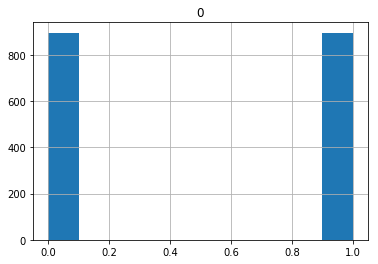

In [31]:
# let's check the results
X_imb_smote = pd.DataFrame(X_imb_smote)
y_imb_smote = pd.DataFrame(y_imb_smote)

y_imb_smote.hist()

In [32]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_smote)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_smote.values
plot3DClusters(test)

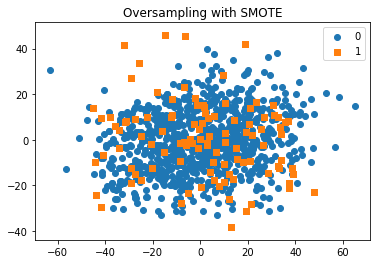

In [33]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_smote)

plot2DClusters(X, y_imb_smote[0],label='Oversampling with SMOTE')

#### 2.2 Over Sampling with ADASYN
ADAptive SYNthetic is based on the idea of generating minority data samples according to their distributions using K nearest neighbour. <br>
Difference between SMOTE and ADASYN is that SMOTE generates equal number of synthetic samples for each minority sample. <br>
Where ADASYN can adaptevely change the weight for minority sample so that it can compensate for the skewed distribution.

In [34]:
# ADASYN
from imblearn.over_sampling import ADASYN

imb_adasyn = ADASYN(ratio='minority')

X_imb_adasyn, y_imb_adasyn = imb_adasyn.fit_sample(temp_X_holder, temp_y_holder)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0921285b38>]],
      dtype=object)

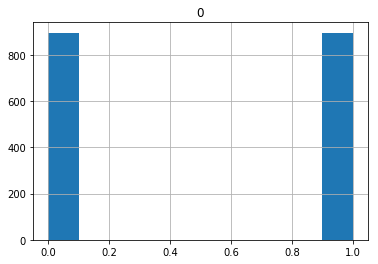

In [35]:
# let's check the results
X_imb_adasyn = pd.DataFrame(X_imb_adasyn)
y_imb_adasyn = pd.DataFrame(y_imb_adasyn)

y_imb_adasyn.hist()


In [36]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_adasyn)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_adasyn.values
plot3DClusters(test)

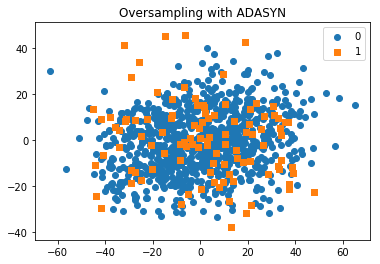

In [37]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_adasyn)

plot2DClusters(X, y_imb_adasyn[0],label='Oversampling with ADASYN')

### 3. Combined Over and Under Sampling
In this scenario we will take adavantage of both Over and Under sampling methods by combining them.

#### 3.1 Over-sampling followed by Under-sampling (SMOTE-Tomek Links)
By combining SMOTE and Tomek Links methods. <br>
Using Tomek links in over-sampled dataset as a cleaning methode. <br>
So instead of removing only the major class from Tomek links, values of both classes are removed.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f092166ea20>]],
      dtype=object)

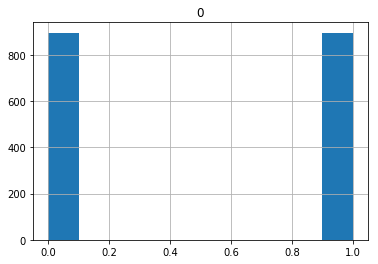

In [38]:
from imblearn.combine import SMOTETomek

imb_smotetomek = SMOTETomek(ratio='auto')

X_imb_smotetomek, y_imb_smotetomek = imb_smotetomek.fit_sample(temp_X_holder, temp_y_holder)

# let's check the results
X_imb_smotetomek = pd.DataFrame(X_imb_smotetomek)
y_imb_smotetomek = pd.DataFrame(y_imb_smotetomek)

y_imb_smotetomek.hist()

In [39]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_smotetomek)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_smotetomek.values
plot3DClusters(test)

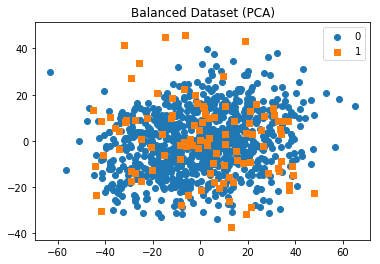

In [40]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_smotetomek)

plot2DClusters(X, y_imb_smotetomek[0],label='Balanced Dataset (PCA)')

#### 3.1 SMOTEENN
SMOTE Edited Nearest Neighbour. <br>
Removes any example whose class label differs from the class label of atleast two of its three nearest neighbours.<br>
Removes more links than Tomek links. <br>
So providing more indepth data cleaning.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09208c8cf8>]],
      dtype=object)

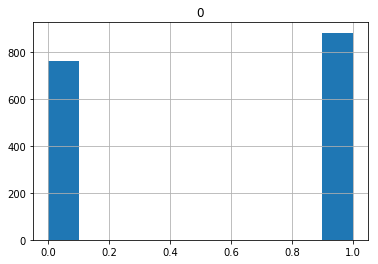

In [41]:
from imblearn.combine import SMOTEENN

imb_smoteenn = SMOTEENN(random_state=0)

X_imb_smoteenn, y_imb_smoteenn = imb_smoteenn.fit_sample(temp_X_holder, temp_y_holder)

# let's check the results
X_imb_smoteenn = pd.DataFrame(X_imb_smoteenn)
y_imb_smoteenn = pd.DataFrame(y_imb_smoteenn)

y_imb_smoteenn.hist()

In [42]:
pca = PCA(n_components = 3)
X = pca.fit_transform(X_imb_smoteenn)

test = pd.DataFrame(columns=['dim-1', 'dim-2', 'dim-3'], data=X)
test['target'] = y_imb_smoteenn.values
plot3DClusters(test)

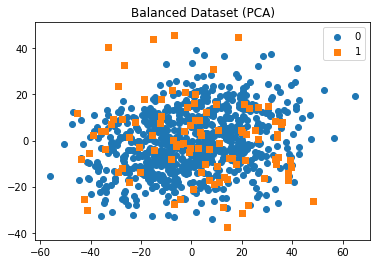

In [43]:
pca = PCA(n_components = 2)
X = pca.fit_transform(X_imb_smoteenn)

plot2DClusters(X, y_imb_smoteenn[0],label='Balanced Dataset (PCA)')

### Training Base Model
Now let's train a base model on these datasets and check how well they are performing. <br>
To avoid the effect of hyperparameters over the sampling methods, we will use grid search to find the optimal hyper parameters.

#### Train-Test split
Split the dataset into test and train.

In [44]:
from sklearn.model_selection import train_test_split

# load dataset
dataset = pd.read_csv('../input/train.csv')
dataset = dataset.sample(n=500)

y = dataset['target']
X = dataset.drop(['ID_code', 'target'], axis=1)

# time to split into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print('Shape of Train data : ', X_train.shape)
print('Shape of Test data : ', X_test.shape)

Shape of Train data :  (350, 200)
Shape of Test data :  (150, 200)


### K-fold validation is the right way
As the dataset is not balanced, it is important to consider that we covered it in testing part also.<br>
The model training on the Over sampled dataset tend to overfit. Hence the K-fold cross validation will help to introduces some <br>
level of randomness so that the model can be genaralized. 

In [45]:
# helper methods for the dataset preperation and benchmarking
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def resample(resampler, X, y):
    print("Resamping with {}".format(resampler.__class__.__name__))
    X_resampled, y_resampled = resampler.fit_sample(X, y)
    return resampler.__class__.__name__, pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

def simulation(resampling_type, X, y):
    lr = LogisticRegression(penalty='l1')
    parameter_grid = {'C':[0.01, 0.1, 1, 10]}
    gs = GridSearchCV(estimator=lr, param_grid=parameter_grid, scoring='accuracy', cv=3, verbose=2) # cv=5
    gs = gs.fit(X.values, y.values.ravel())
    return resampling_type, gs.best_score_, gs.best_params_['C']


### Resample datasets
Let's resample and append datasets to a common variable for the simulation of models.

In [46]:
%%time
# we will use the random under and over sampling methods of imblearn instead that of pandas
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

resampled_datasets = []
resampled_datasets.append(("base dataset", X_train, y_train))
resampled_datasets.append(resample(SMOTE(n_jobs=-1),X_train,y_train))
resampled_datasets.append(resample(RandomOverSampler(),X_train,y_train))
resampled_datasets.append(resample(ClusterCentroids(n_jobs=-1),X_train,y_train))
resampled_datasets.append(resample(NearMiss(n_jobs=-1),X_train,y_train))
resampled_datasets.append(resample(RandomUnderSampler(),X_train,y_train))
resampled_datasets.append(resample(SMOTEENN(),X_train,y_train))
resampled_datasets.append(resample(SMOTETomek(),X_train,y_train))

Resamping with SMOTE
Resamping with RandomOverSampler
Resamping with ClusterCentroids
Resamping with NearMiss
Resamping with RandomUnderSampler
Resamping with SMOTEENN
Resamping with SMOTETomek
CPU times: user 360 ms, sys: 104 ms, total: 464 ms
Wall time: 2.36 s


In [47]:
%%time
benchmark_scores = []
for resampling_type, X, y in resampled_datasets:
    print('______________________________________________________________')
    print('{}'.format(resampling_type))
    benchmark_scores.append(simulation(resampling_type, X, y))
    print('______________________________________________________________')

______________________________________________________________
base dataset
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 ...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
______________________________________________________________
______________________________________________________________
SMOTE
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ...............

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.1s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.1s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.2s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s finished


______________________________________________________________
______________________________________________________________
ClusterCentroids
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.0s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set si

[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.0s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.0s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.1s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=1 .............................................................
[CV] .............................................. C=1, total=   0.2s
[CV] C=10 ............................................................
[CV] ............................................. C=10, total=   0.1s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished


______________________________________________________________
CPU times: user 6.02 s, sys: 76 ms, total: 6.09 s
Wall time: 5.11 s


In [48]:
benchmark_scores_df = pd.DataFrame(columns = ['Methods', 'Accuracy', 'Parameter'], data = benchmark_scores)
benchmark_scores_df

,Methods,Accuracy,Parameter
0,base dataset,0.917143,0.01
1,SMOTE,0.922118,1.00
2,RandomOverSampler,0.936137,1.00
3,ClusterCentroids,0.655172,1.00
4,NearMiss,0.603448,10.00
5,RandomUnderSampler,0.500000,0.01
6,SMOTEENN,0.987805,0.10
7,SMOTETomek,0.923676,1.00


### Evaluation Metrices
Selecting evaluation metrices is very crucial while handling class imbalance. <br>
Suppose you have a class imbalance like <b> major_class : minority_class = 98:2</b>. Then the accuracy for a program which simply generates the major class will be 98%. <br>
So we need to use other metrices like <b>precision, recall, F-1 score, AUC, etc</b>. F-1 score is prefered as it is the weighted sum of precision and recall.

### Let's Train and Evaluate our models

In [49]:
%%time

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve

scores = []
# train models based on benchmark params
for sampling_type,score,param in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = LogisticRegression(penalty = 'l1',C=param)
    for s_type,X,y in resampled_datasets:
        if s_type == sampling_type:
            lr.fit(X.values,y.values.ravel())
            pred_test = lr.predict(X_test.values)
            pred_test_probs = lr.predict_proba(X_test.values)
            probs = lr.decision_function(X_test.values)
            fpr, tpr, thresholds = roc_curve(y_test.values.ravel(),pred_test)
            p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
            scores.append((sampling_type,
                           f1_score(y_test.values.ravel(),pred_test),
                           precision_score(y_test.values.ravel(),pred_test),
                           recall_score(y_test.values.ravel(),pred_test),
                           accuracy_score(y_test.values.ravel(),pred_test),
                           auc(fpr, tpr),
                           auc(p,r,reorder=True),
                           confusion_matrix(y_test.values.ravel(),pred_test)))

Training on base dataset
Training on SMOTE


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.



Training on RandomOverSampler


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated 

Training on ClusterCentroids
Training on NearMiss
Training on RandomUnderSampler
Training on SMOTEENN
Training on SMOTETomek
CPU times: user 948 ms, sys: 0 ns, total: 948 ms
Wall time: 825 ms


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/ranking.py:103: DeprecationWarning:

The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.



In [50]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','auc_pr','confusion_matrix'])
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc_roc,auc_pr,confusion_matrix
0,base dataset,0.000000,0.000000,0.0000,0.893333,0.500000,0.207565,"[[134, 0], [16, 0]]"
1,SMOTE,0.216216,0.190476,0.2500,0.806667,0.561567,0.129947,"[[117, 17], [12, 4]]"
2,RandomOverSampler,0.210526,0.181818,0.2500,0.800000,0.557836,0.170472,"[[116, 18], [12, 4]]"
3,ClusterCentroids,0.109091,0.076923,0.1875,0.673333,0.459422,0.117645,"[[98, 36], [13, 3]]"
4,NearMiss,0.252427,0.149425,0.8125,0.486667,0.630131,0.336481,"[[60, 74], [3, 13]]"
5,RandomUnderSampler,0.218487,0.126214,0.8125,0.380000,0.570429,0.149150,"[[44, 90], [3, 13]]"
6,SMOTEENN,0.189873,0.105634,0.9375,0.146667,0.494869,0.216719,"[[7, 127], [1, 15]]"
7,SMOTETomek,0.216216,0.190476,0.2500,0.806667,0.561567,0.131232,"[[117, 17], [12, 4]]"


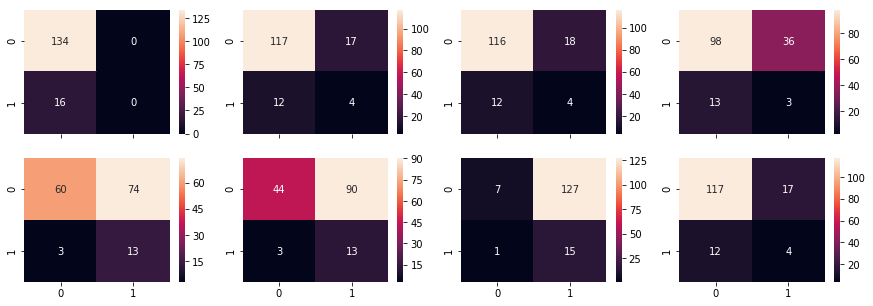

In [51]:
# let's visulize the confusion metrices

f, axes = plt.subplots(2, 4, figsize=(15, 5), sharex=True)
sns.despine(left=True)

sns.heatmap(sampling_results['confusion_matrix'][0], annot=True, fmt='g', ax=axes[0, 0])
sns.heatmap(sampling_results['confusion_matrix'][1], annot=True, fmt='g', ax=axes[0, 1])
sns.heatmap(sampling_results['confusion_matrix'][2], annot=True, fmt='g', ax=axes[0, 2])
sns.heatmap(sampling_results['confusion_matrix'][3], annot=True, fmt='g', ax=axes[0, 3])
sns.heatmap(sampling_results['confusion_matrix'][4], annot=True, fmt='g', ax=axes[1, 0])
sns.heatmap(sampling_results['confusion_matrix'][5], annot=True, fmt='g', ax=axes[1, 1])
sns.heatmap(sampling_results['confusion_matrix'][6], annot=True, fmt='g', ax=axes[1, 2])
sns.heatmap(sampling_results['confusion_matrix'][7], annot=True, fmt='g', ax=axes[1, 3])

### Findings
* Out of all the models <b>RandomOverSampling</b> is the better performing one.
* We can see that f1-score is a better metric that can explain the perfomance of a model.